## Introduction
Joe is a new freshman at Carnegie Mellon University. It is his first time in Pittsburgh and he is not familiar with the restaurants here. He wants to explore the different dining options for different occasions. However, as a busy CS student, he doesn’t have much time to do so. As his friends, we will be helping him to analyze and visualize Pittsburgh restaurant data using the Yelp Fusion API. We will be specifically focusing on the different characteristics (i.e. price, popularity, cuisine distribution, etc.) of restaurants in different regions of Pittsburgh. We will also create visualizations that Joe can use to find restaurants for his needs quickly and easily. 

## Installing Libraries
Let us first install the various library that we will use to analysis Pittsburgh restaurants for Joe. We can install the libraries by running the following commands.
  ``` 
  $ python -m pip install pandas 

  $ python -m pip install requests

  $ python -m pip install time

  # python -m pip install matplotlib

  $ python -m pip install seaborn

  $ python -m pip install tqdm
  ```

Run the following cell to import the libraries into the notebook.

In [3]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Collecting Yelp Restaurant Data


The way we will collect data on Pittsburgh restaurants is through querying the [Yelp Fusion API](https://fusion.yelp.com/). The Yelp API contains a [business search](https://www.yelp.com/developers/documentation/v3/business_search) endpoint which we can use to search for Pittsburgh restaurants. This is very similar to what we have done in homework 1. To this end, we can reuse some of our code from that assignment to use the Requests library to query the endpoint. 

In order to use the Yelp Fusion API, you will need to generate an [API key](https://www.yelp.com/developers/v3/manage_app).

In [4]:
API_KEY = "55OogUtwnlPBe3XofvQBDpHxADO1WaxgA1JFjegDtimMsoX6oqTkVJ6Gx2ry7g07D_qxm3Hdnk_cAziTh_so6rwjekkLoNDZrvTVm2_nJLuida5u70FgaFSYQrz5YXYx"

In [5]:
def yelp_search(query):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search term

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the query
        businesses (list): list of dicts representing each business
    """

    payload = {'location': query}
    headers = {'Authorization': 'Bearer '+ API_KEY}
    response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=payload)
    response.raise_for_status()
    json = response.json()

    return json['total'], json['businesses']

In homework 1, we retrieved Pittsburgh businesses and stored it as a list of JSON business objects. In order to best help Joe through conducting analysis on the data, we will alter the ```all_restaurants``` function to return a normalized Pandas dataframe instead.

In [6]:
def all_restaurants(query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """

    payload = {'location': query, 'categories': 'restaurants', 'limit': 50}
    headers = {'Authorization': 'Bearer '+ API_KEY}
    offset = 0
    res = []
    
    # call endpoint until no additional data is received
    while(offset < 1000):
        payload['offset'] = offset
        try:
            response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=payload)
            response.raise_for_status()
        except requests.exceptions.HTTPError:
            break
        
        json = response.json()

        if len(json['businesses']) < 1:
            break

        offset += len(json['businesses'])
        res.extend(json['businesses'])
        time.sleep(0.5)
    return pd.json_normalize(res)

The limitation of the [business search](https://www.yelp.com/developers/documentation/v3/business_search) endpoint is that it can only return up to 1000 businesses for a single search using the pagination values. We will attempt to get more data by searching restaurants in each possible ZipCode for Pittsburgh. We will then remove the duplicate restaurants to get a master list of Pittsburgh restaurants. Generating the master list takes a decently long time (est. 10 min). We can visualize this using the ```tqdm``` progress bar.

In [7]:
master_df = pd.DataFrame()
pittsburgh_zipcodes = [15106, 15120, 15201, 15203, 15204, 15205, 15206, 15207, 15208, 15210, 15211, 15212, 15213, 15214, 15215, 15216, 15217, 15218, 15219, 15220, 15221, 15222, 15224, 15226, 15227, 15232, 15233, 15234, 15235, 15236, 15238, 15260, 15290]

# est. runtime 10 min
for zip in tqdm(pittsburgh_zipcodes):
  df = all_restaurants(zip)
  # strict checking of zip code, can comment out for more data
  df = df[df['location.zip_code'] == str(zip)]
  master_df = pd.concat([master_df, df])

master_df = master_df.drop_duplicates(subset=['id'])


100%|██████████| 33/33 [10:06<00:00, 18.38s/it]


We can see that this method gives us about 1400 restaurants. Now its time to use this data to help Joe become more familiar with Pittsburgh restaurants!

In [8]:
len(master_df)

1449

## Number of Restaurants per ZipCode

<AxesSubplot:title={'center':'Number of Restaurant by ZipCode'}, xlabel='ZipCode', ylabel='Count'>

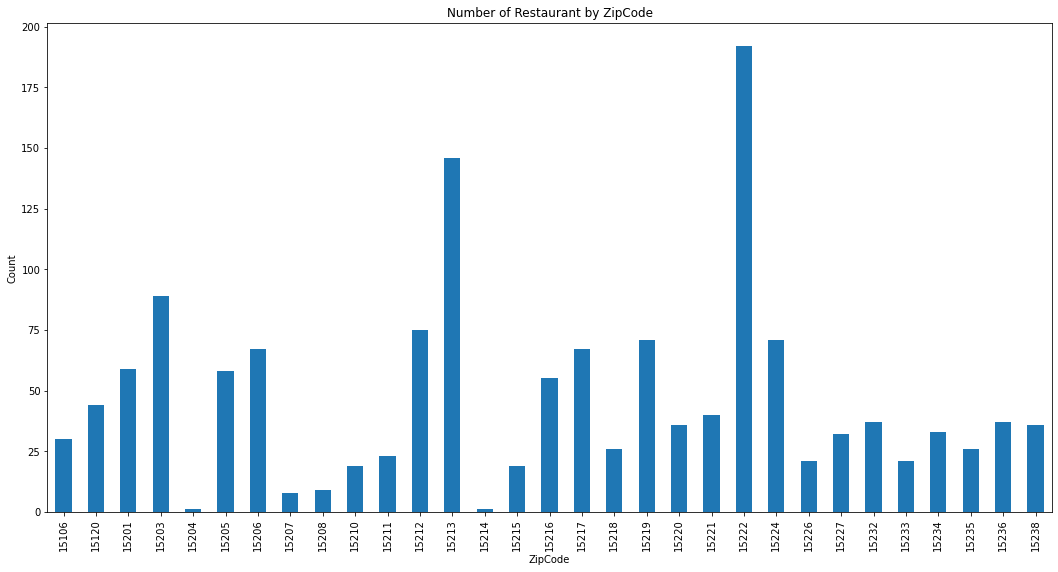

In [9]:
count_zip = master_df.groupby('location.zip_code').size()
count_zip.plot.bar(xlabel="ZipCode", ylabel="Count", title="Number of Restaurant by ZipCode", figsize=(18,9))

## Distribution of Restaurant Transaction Type by ZipCode

<AxesSubplot:title={'center':'Restaurant Transaction Type by ZipCode'}, xlabel='ZipCode', ylabel='Count'>

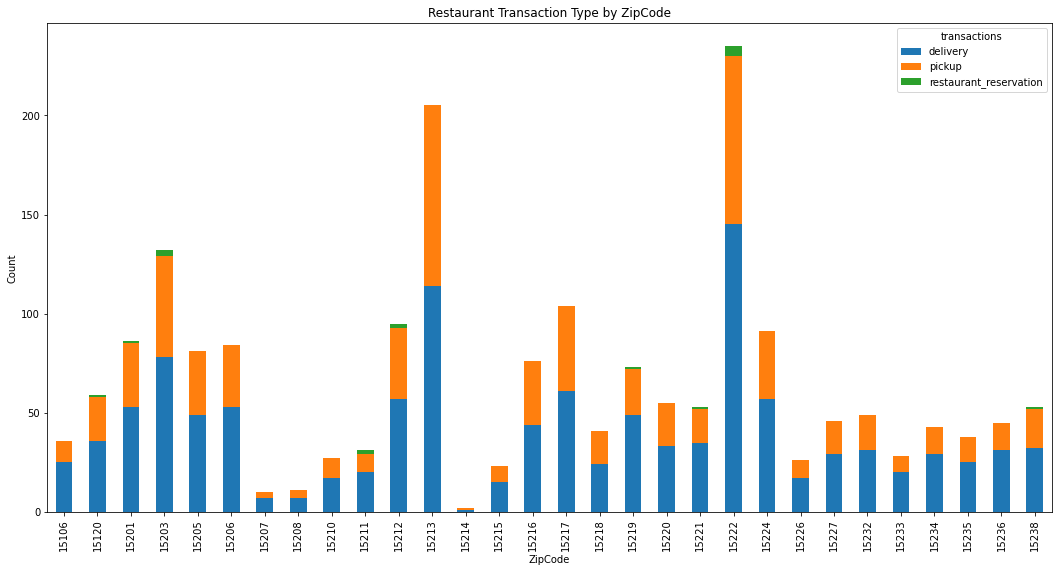

In [10]:
transactions_df = master_df.explode('transactions')
transactions_df = transactions_df.dropna(subset=['transactions'])
transactions_gp = transactions_df.groupby('location.zip_code')['transactions'].value_counts().unstack().fillna(0)
transactions_gp.plot.bar(stacked=True, title="Restaurant Transaction Type by ZipCode", xlabel="ZipCode", ylabel="Count", figsize=(18,9))

## Distribution of Restaurant Price by ZipCode

<AxesSubplot:title={'center':'Restaurant Price by ZipCode'}, xlabel='ZipCode', ylabel='Count'>

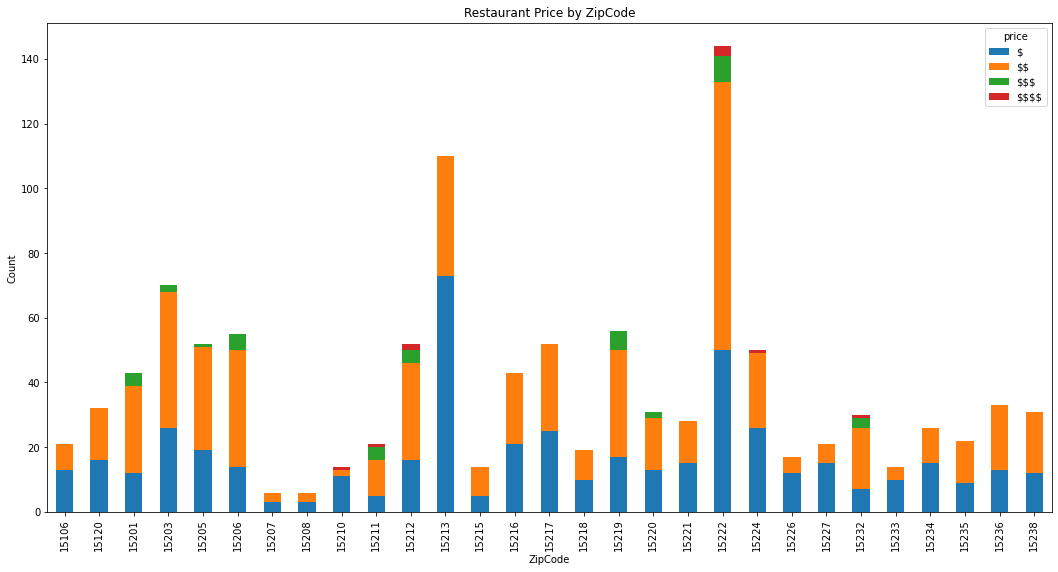

In [11]:
price_df = master_df.dropna(subset=['price'])
price_gp = price_df.groupby('location.zip_code')['price'].value_counts().unstack().fillna(0)

# add escape char to '$' to avoid parsing error
price_gp = price_gp.rename(columns={'$': '\$', '$$': '\$\$', '$$$': '\$\$\$', '$$$$': '\$\$\$\$'})
price_gp.plot.bar(stacked=True, title="Restaurant Price by ZipCode", xlabel="ZipCode", ylabel="Count", figsize=(18,9))

## Distribution of Chinese Restaurant Star Rating by ZipCode

In [12]:
categories_df = master_df.explode('categories')
categories_df['categories'] = categories_df['categories'].apply(lambda x: x['title'])

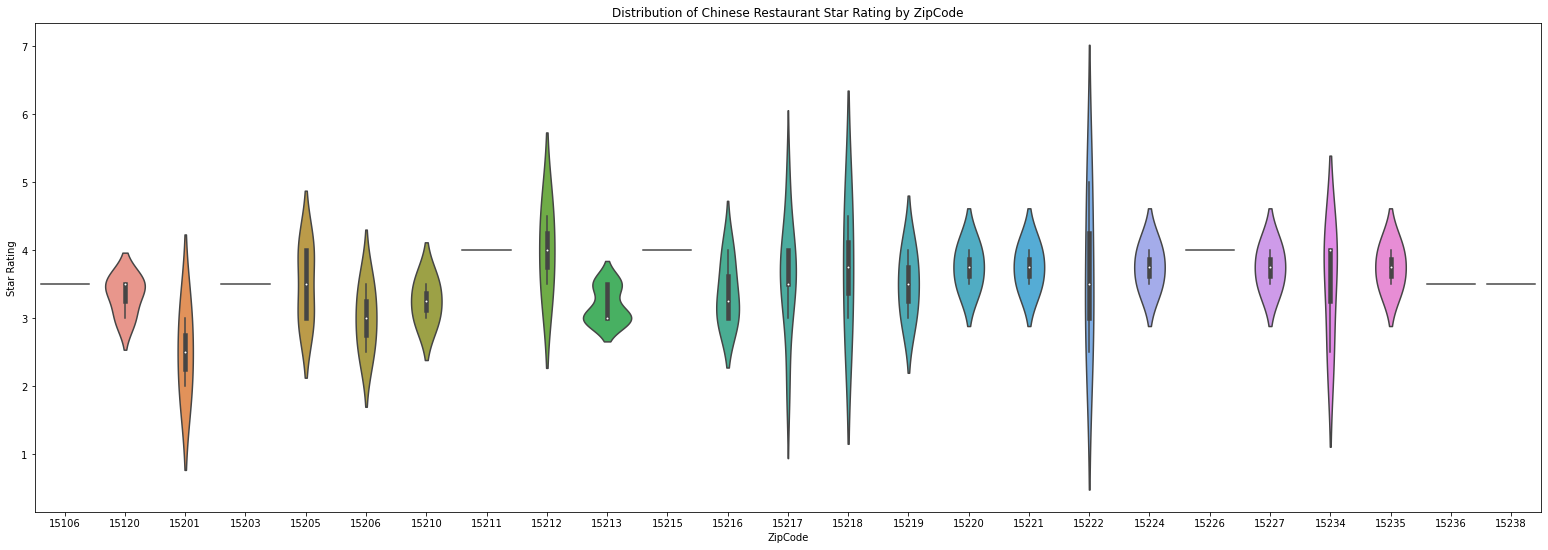

In [13]:
t = categories_df[categories_df['categories'] == 'Chinese']
t = t[['location.zip_code', 'rating']]
fig, ax = plt.subplots(figsize=(27,9))
ax = sns.violinplot(x='location.zip_code', y='rating', data=t)
ax.set_xlabel('ZipCode')
ax.set_ylabel('Star Rating')
ax.set_title('Distribution of Chinese Restaurant Star Rating by ZipCode')
plt.show()

## Distribution of Restaurant Star Rating by ZipCode

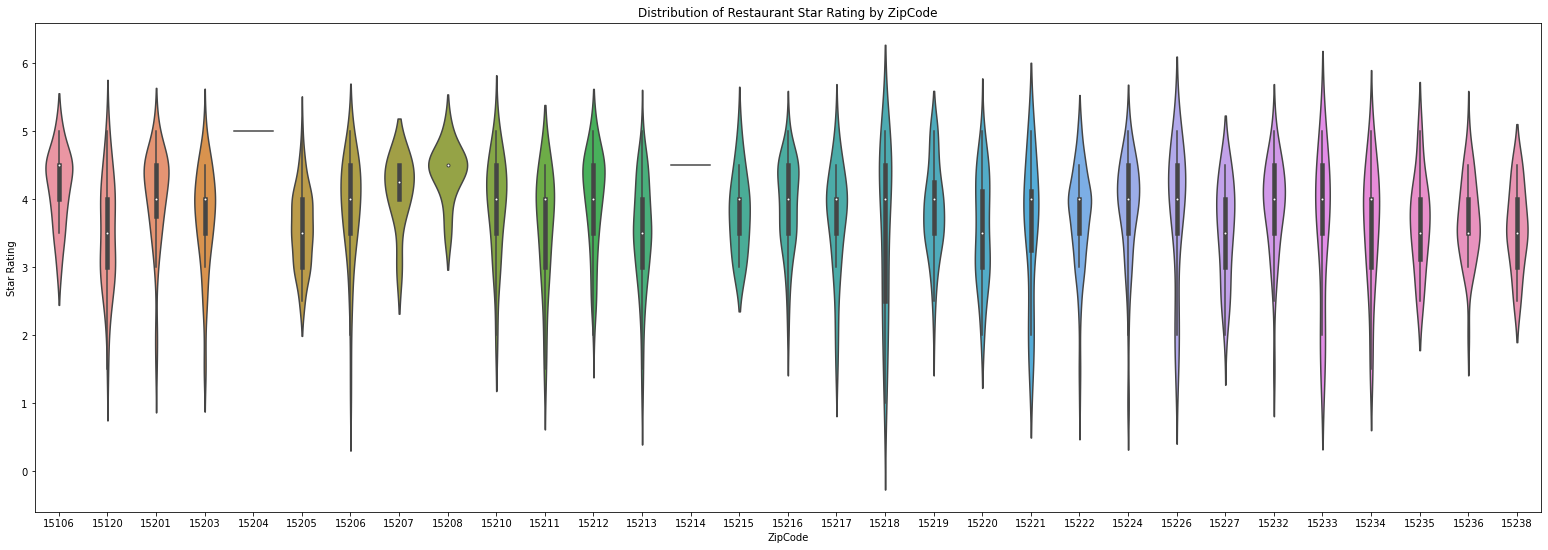

In [14]:
t = master_df[['location.zip_code', 'rating']]
fig, ax = plt.subplots(figsize=(27,9))
ax = sns.violinplot(x='location.zip_code', y='rating', data=t)
ax.set_xlabel('ZipCode')
ax.set_ylabel('Star Rating')
ax.set_title('Distribution of Restaurant Star Rating by ZipCode')
plt.show()